UCSDped1 - Images Train charg√©es : (6800, 64, 64)
UCSDped1 - Donn√©es sauvegard√©es dans : C:\Users\hedi_meg\PycharmProjects\UCSDped1_train.npy


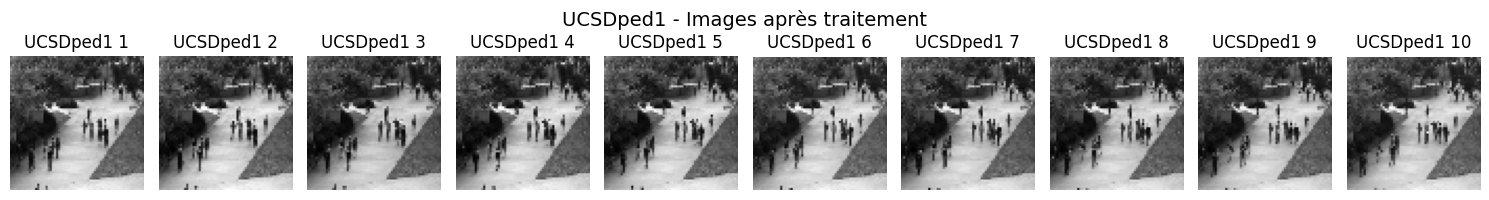

UCSDped1 - Pr√©traitement termin√© avec succ√®s.
UCSDped2 - Images Train charg√©es : (2550, 64, 64)
UCSDped2 - Donn√©es sauvegard√©es dans : C:\Users\hedi_meg\PycharmProjects\UCSDped2_train.npy


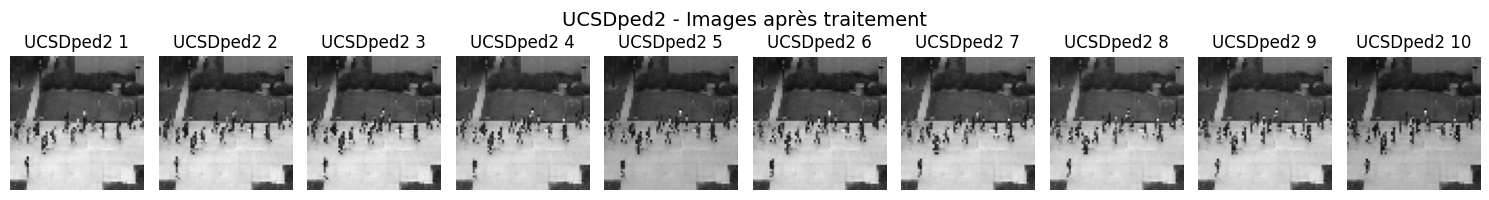

UCSDped2 - Pr√©traitement termin√© avec succ√®s.


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import self

# Param√®tres
taille_image = (64, 64)
bases_donnees = {
    "UCSDped1": r"D:\Files\Documents\COURS\ESPRIT\Mission entreprise 3ALINFO4\Anomaly detection\UCSDped1",
    "UCSDped2": r"D:\Files\Documents\COURS\ESPRIT\Mission entreprise 3ALINFO4\Anomaly detection\UCSDped2"
}
mode = "Train"

dossier_sortie = r"C:\Users\hedi_meg\PycharmProjects"  # chemin simple pour test

def lire_image(chemin_image):
    if not chemin_image.lower().endswith(".tif"):
        return None
    img = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image introuvable ou corrompue :", chemin_image)
        return None
    img = cv2.resize(img, taille_image)
    img = img.astype('float32') / 255.0
    return img

if not os.path.exists(dossier_sortie):
    os.makedirs(dossier_sortie)

for nom_dataset, dossier_base in bases_donnees.items():
    chemin_donnees = os.path.join(dossier_base, mode)

    clips = sorted([
        nom for nom in os.listdir(chemin_donnees)
        if os.path.isdir(os.path.join(chemin_donnees, nom))
    ])

    toutes_les_images = []
    for clip in clips:
        chemin_clip = os.path.join(chemin_donnees, clip)
        images = sorted(os.listdir(chemin_clip))
        for nom_img in images:
            chemin_img = os.path.join(chemin_clip, nom_img)
            img = lire_image(chemin_img)
            if img is not None:
                toutes_les_images.append(img)

    toutes_les_images = np.array(toutes_les_images)
    print(f"{nom_dataset} - Images {mode} charg√©es : {toutes_les_images.shape}")

    nom_fichier = os.path.join(dossier_sortie, f"{nom_dataset}_{mode.lower()}.npy")
    np.save(nom_fichier, toutes_les_images)
    print(f"{nom_dataset} - Donn√©es sauvegard√©es dans : {nom_fichier}")

    # Visualisation
    nb_afficher = 10
    plt.figure(figsize=(15, 2))
    for i in range(min(nb_afficher, len(toutes_les_images))):
        plt.subplot(1, nb_afficher, i + 1)
        plt.imshow(toutes_les_images[i], cmap='gray')
        plt.axis('off')
        plt.title(f"{nom_dataset} {i+1}")
    plt.suptitle(f"{nom_dataset} - Images apr√®s traitement", fontsize=14)
    plt.tight_layout()
    plt.show()

    print(f"{nom_dataset} - Pr√©traitement termin√© avec succ√®s.")

In [3]:
import torch
import torch.nn as nn

class OptimizedCAE3D(nn.Module):
    def __init__(self):
        super(OptimizedCAE3D, self).__init__()

        # ‚öôÔ∏è Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1),  # (1,16,64,64) -> (16,16,64,64)
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),                                # (16,16,32,32)

            nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),  # (32,16,32,32)
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),                                # (32,8,16,16)

            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),  # (64,8,16,16)
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),                                # (64,4,8,8)
        )

        # üîÅ Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2),   # (32,8,16,16)
            nn.BatchNorm3d(32),
            nn.ReLU(),

            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),   # (16,16,32,32)
            nn.BatchNorm3d(16),
            nn.ReLU(),

            nn.ConvTranspose3d(16, 1, kernel_size=(1, 2, 2), stride=(1, 2, 2)),  # (1,16,64,64)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
# ‚úÖ Initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = OptimizedCAE3D().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
# üì¶ Imports
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ‚öôÔ∏è Config
SEQ_LEN = 16
BATCH_SIZE = 4
IMG_SIZE = 64
EPOCHS = 10
DATA_DIR = r"C:\Users\hedi_meg\PycharmProjects"  # dossier o√π sont les .npy

# üß† Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è GPU utilis√© :" if torch.cuda.is_available() else "‚ö†Ô∏è Entra√Ænement sur CPU uniquement")
if torch.cuda.is_available():
    print("üìå", torch.cuda.get_device_name(0))

# üìÇ Dataset personnalis√© depuis .npy
class UCSDNpyDataset(Dataset):
    def __init__(self, npy_path, seq_len):
        data = np.load(npy_path)
        self.sequences = []
        for i in range(len(data) - seq_len + 1):
            clip = data[i:i + seq_len]  # (seq_len, 64, 64)
            self.sequences.append(clip)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx]  # (seq_len, 64, 64)
        x = np.expand_dims(x, axis=1)  # (seq_len, 1, 64, 64)
        x = torch.from_numpy(x).float()  # to tensor
        x = x.permute(1, 0, 2, 3)  # -> (1, seq_len, 64, 64)
        return x

# üß† Mod√®le CAE optimis√©
class OptimizedCAE3D(nn.Module):
    def __init__(self):
        super(OptimizedCAE3D, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2))
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            nn.ConvTranspose3d(16, 1, kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# üìä Initialisation
model = OptimizedCAE3D().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# üìÅ Charger UCSDped1 et UCSDped2
npy_files = [
    os.path.join(DATA_DIR, "UCSDped1_train.npy"),
    os.path.join(DATA_DIR, "UCSDped2_train.npy")
]

train_sequences = []
for file in npy_files:
    dataset = UCSDNpyDataset(file, seq_len=SEQ_LEN)
    train_sequences.extend(dataset.sequences)

train_dataset = torch.utils.data.TensorDataset(
    torch.stack([
        torch.from_numpy(s).unsqueeze(0).float().permute(0, 1, 2, 3)  # (1,16,64,64)
        for s in train_sequences
    ])
)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# üîÅ Entra√Ænement
print("üöÄ D√©but de l'entra√Ænement...\n")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = batch[0].to(device)  # extraire le batch
        output = model(batch)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"‚úÖ Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.6f}")

print("\nüéâ Entra√Ænement termin√©.")


üñ•Ô∏è GPU utilis√© :
üìå NVIDIA GeForce RTX 4050 Laptop GPU
üöÄ D√©but de l'entra√Ænement...

‚úÖ Epoch [1/10] - Loss: 0.007036
‚úÖ Epoch [2/10] - Loss: 0.002669
‚úÖ Epoch [3/10] - Loss: 0.002150
‚úÖ Epoch [4/10] - Loss: 0.001891
‚úÖ Epoch [5/10] - Loss: 0.001737
‚úÖ Epoch [6/10] - Loss: 0.001621
‚úÖ Epoch [7/10] - Loss: 0.001545
‚úÖ Epoch [8/10] - Loss: 0.001488
‚úÖ Epoch [9/10] - Loss: 0.001448
‚úÖ Epoch [10/10] - Loss: 0.001410

üéâ Entra√Ænement termin√©.


In [30]:
# üì¶ 1. Chargement du mod√®le et passage en √©valuation
model.eval()  # D√©sactive le dropout/batchnorm

OptimizedCAE3D(
  (encoder): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose3d(64, 32, kernel_size=(2, 2, 2), stride

In [43]:
# üß™ 2. Charger les donn√©es de test pour UCSD PED1
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# üîÅ Param√®tres
taille_image = (64, 64)
clip_len = 16  # nombre d‚Äôimages par s√©quence (comme en training)

# üîÅ Chemin du dossier test
chemin_test = r"D:\Files\Documents\COURS\ESPRIT\Mission entreprise 3ALINFO4\Anomaly detection\UCSDped1\Test"

# üîÅ R√©cup√©ration des dossiers (Test001, Test002, etc.)
dossiers_test = sorted([f for f in os.listdir(chemin_test) if f.startswith("Test") and not f.endswith("_gt")])

# üîÅ Lire toutes les images test en les empilant
toutes_les_images = []

for dossier in dossiers_test:
    chemin_dossier = os.path.join(chemin_test, dossier)
    fichiers = sorted([f for f in os.listdir(chemin_dossier) if f.endswith(".tif")])

    for fichier in fichiers:
        chemin_image = os.path.join(chemin_dossier, fichier)
        img = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, taille_image)
        img = img.astype(np.float32) / 255.0
        toutes_les_images.append(img)

# üîÅ D√©coupe en s√©quences (sliding window)
toutes_les_images = np.array(toutes_les_images)
sequences_test = [toutes_les_images[i:i+clip_len] for i in range(len(toutes_les_images) - clip_len + 1)]

# üîÅ Convertir en tensor dataset
tensor_list = []
for s in sequences_test:
    t = torch.from_numpy(s).float()     # (16, 64, 64)
    t = t.unsqueeze(1)                  # (16, 1, 64, 64)
    t = t.permute(1, 0, 2, 3)           # (1, 16, 64, 64)
    tensor_list.append(t)

test_dataset = TensorDataset(torch.stack(tensor_list))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"‚úÖ S√©quences test charg√©es : {len(test_dataset)}")


‚úÖ S√©quences test charg√©es : 7185


In [105]:
# üß™ 2. Charger les donn√©es de test pour UCSD PED2
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# üîÅ Param√®tres
taille_image = (64, 64)
clip_len = 16  # nombre d‚Äôimages par s√©quence (comme en training)

# üîÅ Chemin du dossier test
chemin_test = r"D:\Files\Documents\COURS\ESPRIT\Mission entreprise 3ALINFO4\Anomaly detection\UCSDped2\Test"

# üîÅ R√©cup√©ration des dossiers (Test001, Test002, etc.)
dossiers_test = sorted([f for f in os.listdir(chemin_test) if f.startswith("Test") and not f.endswith("_gt")])

# üîÅ Lire toutes les images test en les empilant
toutes_les_images = []

for dossier in dossiers_test:
    chemin_dossier = os.path.join(chemin_test, dossier)
    fichiers = sorted([f for f in os.listdir(chemin_dossier) if f.endswith(".tif")])

    for fichier in fichiers:
        chemin_image = os.path.join(chemin_dossier, fichier)
        img = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, taille_image)
        img = img.astype(np.float32) / 255.0
        toutes_les_images.append(img)

# üîÅ D√©coupe en s√©quences (sliding window)
toutes_les_images = np.array(toutes_les_images)
sequences_test = [toutes_les_images[i:i+clip_len] for i in range(len(toutes_les_images) - clip_len + 1)]

# üîÅ Convertir en tensor dataset
tensor_list = []
for s in sequences_test:
    t = torch.from_numpy(s).float()     # (16, 64, 64)
    t = t.unsqueeze(1)                  # (16, 1, 64, 64)
    t = t.permute(1, 0, 2, 3)           # (1, 16, 64, 64)
    tensor_list.append(t)

test_dataset = TensorDataset(torch.stack(tensor_list))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"‚úÖ S√©quences test charg√©es : {len(test_dataset)}")

‚úÖ S√©quences test charg√©es : 1995


In [106]:
# üîÅ 3. Calcul des erreurs de reconstruction (loss MSE)

import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()  # Met le mod√®le en mode √©valuation (important)
all_losses = []

with torch.no_grad():  # Pas besoin de calculer les gradients pendant le test
    for batch in test_loader:
        x = batch[0].to(device)  # x shape: (1, 1, 16, 64, 64)
        recon = model(x)         # reconstruction par le mod√®le
        loss = F.mse_loss(recon, x, reduction='mean').item()
        all_losses.append(loss)

print(f"‚úÖ Calcul des erreurs termin√© pour {len(all_losses)} clips")

‚úÖ Calcul des erreurs termin√© pour 1995 clips


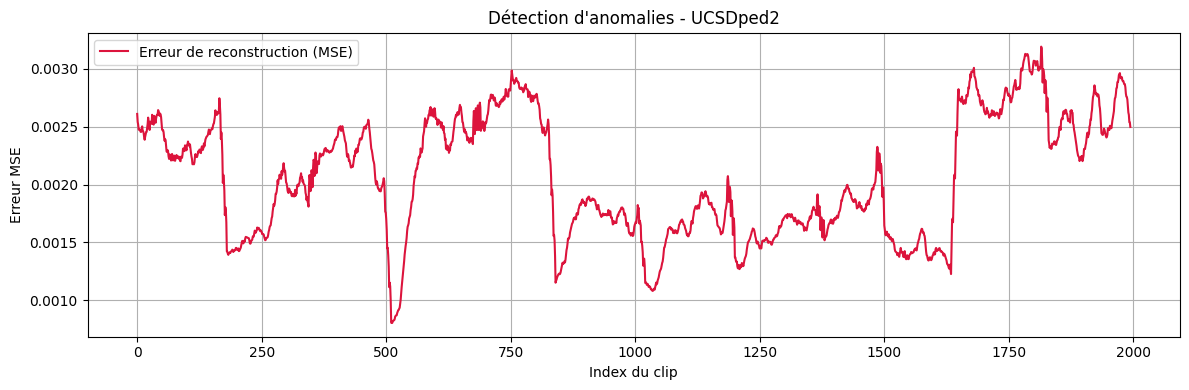

In [107]:
# üìà 4. Visualisation des scores d‚Äôanomalies

plt.figure(figsize=(12, 4))
plt.plot(all_losses, color='crimson', label='Erreur de reconstruction (MSE)')
plt.xlabel("Index du clip")
plt.ylabel("Erreur MSE")
plt.title("D√©tection d'anomalies - UCSDped2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [108]:
# üß† seuil d‚Äôanomalie (d√©tection automatique)

import numpy as np

threshold = np.mean(all_losses) + 2 * np.std(all_losses)
print(f"üîç Seuil d‚Äôanomalie automatique : {threshold:.5f}")

# Index des clips consid√©r√©s comme anormaux
anomalous_clips = [i for i, l in enumerate(all_losses) if l > threshold]
print(f"üö® Clips suspects : {anomalous_clips}")

üîç Seuil d‚Äôanomalie automatique : 0.00310
üö® Clips suspects : [1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1815, 1816]


In [88]:
# visualisation frame par frame (entr√©e vs reconstruction)

import matplotlib.pyplot as plt

def afficher_comparaison_clip(input_tensor, recon_tensor, clip_index=None):
    """
    Affiche les 16 frames d‚Äôun clip : originales en haut, reconstruites en bas
    """
    input_np = input_tensor.squeeze().cpu().numpy()     # (16, 64, 64)
    recon_np = recon_tensor.squeeze().cpu().numpy()     # (16, 64, 64)

    fig, axs = plt.subplots(2, 16, figsize=(20, 3))
    for i in range(16):
        axs[0, i].imshow(input_np[i], cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Frame {i+1}")

        axs[1, i].imshow(recon_np[i], cmap='gray')
        axs[1, i].axis('off')

    axs[0, 0].set_ylabel("Entr√©e", fontsize=12)
    axs[1, 0].set_ylabel("Reconstr.", fontsize=12)

    if clip_index is not None:
        fig.suptitle(f"Clip {clip_index} - Reconstruction vs Original", fontsize=14)
    plt.tight_layout()
    plt.show()

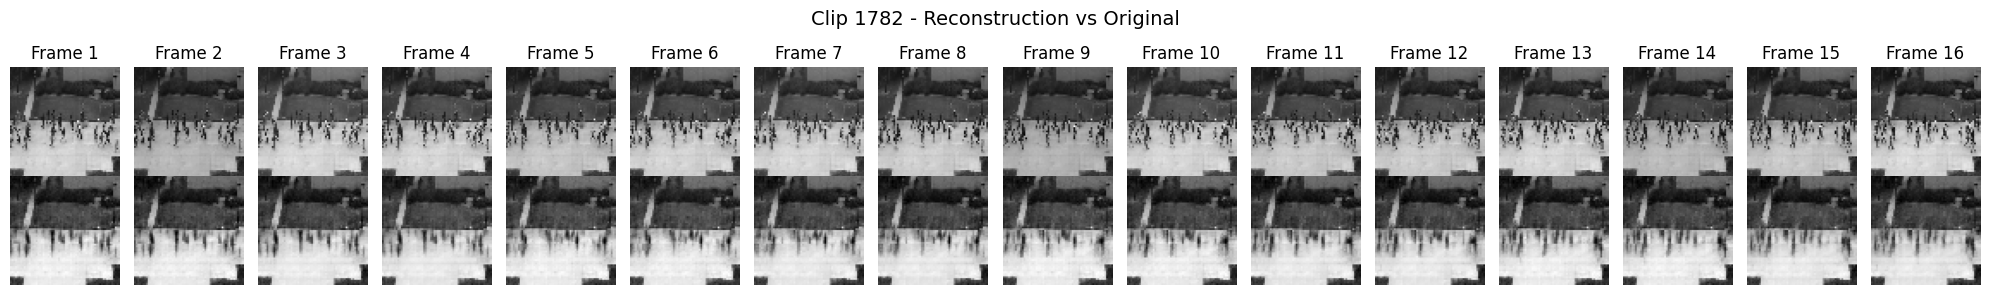

In [91]:
clip_idx = 1782  # remplace par un index r√©el du dataset
x = test_dataset[clip_idx][0].unsqueeze(0).to(device)   # shape: (1, 1, 16, 64, 64)
with torch.no_grad():
    recon = model(x)
afficher_comparaison_clip(x, recon, clip_index=clip_idx)


In [92]:
# ‚úÖ √âtape 1 : Charger les GT √† partir d‚Äôimages .bmp
# ‚úÖ √âtape 2 : Convertir en labels par clip

import os
import cv2
import numpy as np

def charger_tous_gt_images(dossier_ucsd, clip_len=16):
    """
    Parcourt tous les dossiers *_gt dans un dossier UCSD (UCSDped1 ou ped2)
    et retourne les labels par frame ET par clip.
    """
    gt_global_frames = []

    # Trouver tous les dossiers *_gt
    dossiers_gt = sorted([d for d in os.listdir(dossier_ucsd) if d.endswith("_gt")])

    for dossier in dossiers_gt:
        chemin_dossier = os.path.join(dossier_ucsd, dossier)
        fichiers = sorted([f for f in os.listdir(chemin_dossier) if f.endswith(".bmp")])

        for fichier in fichiers:
            chemin_img = os.path.join(chemin_dossier, fichier)
            img = cv2.imread(chemin_img, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            label = 1 if np.any(img > 0) else 0
            gt_global_frames.append(label)

    print(f"‚úÖ Total des frames GT charg√©es : {len(gt_global_frames)}")

    # Conversion en labels par clip
    gt_clips = []
    for i in range(len(gt_global_frames) - clip_len + 1):
        gt_clips.append(1 if any(gt_global_frames[i:i+clip_len]) else 0)

    print(f"üéØ S√©quences g√©n√©r√©es : {len(gt_clips)}")
    return gt_global_frames, gt_clips

In [57]:
# üîß Utilisation pour UCSDped1 :

chemin_ucsd_ped1 = r"D:\Files\Documents\COURS\ESPRIT\Mission entreprise 3ALINFO4\Anomaly detection\UCSDped1\test"
gt_frame_labels, gt_clip_labels = charger_tous_gt_images(chemin_ucsd_ped1)

‚úÖ Total des frames GT charg√©es : 2000
üéØ S√©quences g√©n√©r√©es : 1985


In [93]:
# üîß Pour UCSDped2 :

chemin_ucsd_ped2 = r"D:\Files\Documents\COURS\ESPRIT\Mission entreprise 3ALINFO4\Anomaly detection\UCSDped2\test"
gt_frame_labels, gt_clip_labels = charger_tous_gt_images(chemin_ucsd_ped2)

‚úÖ Total des frames GT charg√©es : 2010
üéØ S√©quences g√©n√©r√©es : 1995


In [65]:
dossiers_gt_existants = ['Test003', 'Test004', 'Test014', 'Test018', 'Test019', 'Test021', 'Test022', 'Test023', 'Test024', 'Test032']

# Liste des dossiers GT existants
dossiers_gt_existants = sorted([
    d.replace('_gt', '') for d in os.listdir(chemin_ucsd_ped1)
    if d.endswith('_gt')
])

In [104]:
# ‚úÖ √âtape 3 : √âvaluer les performances du mod√®le pour ped1 (fix)
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import classification_report

# Chemins de base
clip_len = 16
chemin_ucsd = r"D:\Files\Documents\COURS\ESPRIT\Mission entreprise 3ALINFO4\Anomaly detection\UCSDped1"
chemin_test = os.path.join(chemin_ucsd, "Test")

# Liste manuelle des dossiers avec GT
dossiers_valides = [
    'Test003', 'Test004', 'Test014', 'Test018', 'Test019',
    'Test021', 'Test022', 'Test023', 'Test024', 'Test032'
]

# Appareil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class UCSDFilteredDataset(Dataset):
    def __init__(self, dossier_test, dossiers_autorises, clip_len=16):
        self.clip_len = clip_len
        self.sequences = []

        for dossier in sorted(dossiers_autorises):
            chemin_dossier = os.path.join(dossier_test, dossier)
            fichiers = sorted([f for f in os.listdir(chemin_dossier) if f.endswith(".tif")])
            frames = []
            print(f"{dossier}: {len(frames)} frames ‚Üí {len(frames) - clip_len + 1} clips")

            for f in fichiers:
                chemin_image = os.path.join(chemin_dossier, f)
                img = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, (64, 64)).astype('float32') / 255.0
                frames.append(img)

            for i in range(len(frames) - clip_len + 1):
                clip = frames[i:i+clip_len]
                self.sequences.append(np.stack(clip))  # [16,64,64]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx]  # [16,64,64]
        x = torch.from_numpy(x).unsqueeze(0)  # ‚Üí [1,16,64,64] : 1 canal, 16 frames (profondeur)
        return x
def charger_gt_clips_pour_dossiers(chemin_ucsd, dossiers_autorises, clip_len=16):
    gt_global_frames = []

    for dossier in dossiers_autorises:
        dossier_gt = dossier + "_gt"
        chemin_dossier_gt = os.path.join(chemin_test, dossier_gt)
        fichiers = sorted([f for f in os.listdir(chemin_dossier_gt) if f.endswith(".bmp")])
        print(f"{dossier_gt}: {len(fichiers)} frames GT ‚Üí {len(fichiers) - clip_len + 1} clips")
        for f in fichiers:
            chemin_img = os.path.join(chemin_dossier_gt, f)
            img = cv2.imread(chemin_img, cv2.IMREAD_GRAYSCALE)
            label = 1 if np.any(img > 0) else 0
            gt_global_frames.append(label)

    gt_clips = []
    for i in range(len(gt_global_frames) - clip_len + 1):
        gt_clips.append(1 if any(gt_global_frames[i:i+clip_len]) else 0)

    return gt_clips


# Cr√©er le DataLoader
dataset = UCSDFilteredDataset(chemin_test, dossiers_valides, clip_len=clip_len)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Pr√©dictions du mod√®le
all_losses = []
model.eval()
with torch.no_grad():
    for batch in loader:
        x = batch.to(device)
        recon = model(x)
        loss = F.mse_loss(recon, x, reduction='mean').item()
        all_losses.append(loss)

# Charger les labels GT
gt_clip_labels = charger_gt_clips_pour_dossiers(chemin_ucsd, dossiers_valides, clip_len=clip_len)

# V√©rification
print(f"Clips pr√©dits  : {len(all_losses)}")
print(f"Clips GT labels: {len(gt_clip_labels)}")
assert len(all_losses) == len(gt_clip_labels), "Les longueurs de pr√©diction et de GT ne correspondent pas."

# Seuil automatique : 95e percentile
threshold = np.percentile(all_losses, 95)
preds = [1 if l > threshold else 0 for l in all_losses]

# Rapport
print(f"\nSeuil choisi : {threshold:.6f}")
print(classification_report(gt_clip_labels, preds, digits=3))


Test003: 0 frames ‚Üí -15 clips
Test004: 0 frames ‚Üí -15 clips
Test014: 0 frames ‚Üí -15 clips
Test018: 0 frames ‚Üí -15 clips
Test019: 0 frames ‚Üí -15 clips
Test021: 0 frames ‚Üí -15 clips
Test022: 0 frames ‚Üí -15 clips
Test023: 0 frames ‚Üí -15 clips
Test024: 0 frames ‚Üí -15 clips
Test032: 0 frames ‚Üí -15 clips
Test003_gt: 200 frames GT ‚Üí 185 clips
Test004_gt: 200 frames GT ‚Üí 185 clips
Test014_gt: 200 frames GT ‚Üí 185 clips
Test018_gt: 200 frames GT ‚Üí 185 clips
Test019_gt: 200 frames GT ‚Üí 185 clips
Test021_gt: 200 frames GT ‚Üí 185 clips
Test022_gt: 200 frames GT ‚Üí 185 clips
Test023_gt: 200 frames GT ‚Üí 185 clips
Test024_gt: 200 frames GT ‚Üí 185 clips
Test032_gt: 200 frames GT ‚Üí 185 clips
Clips pr√©dits  : 1850
Clips GT labels: 1985


AssertionError: Les longueurs de pr√©diction et de GT ne correspondent pas.

In [94]:
# ‚úÖ √âtape 3.1 : Cr√©er un test_loader filtr√© uniquement sur ces dossiers

class UCSDFilteredDataset(Dataset):
    def __init__(self, dossier_test, dossiers_autorises, clip_len=16, transform=None):
        self.clip_len = clip_len
        self.transform = transform
        self.sequences = []

        for dossier in sorted(os.listdir(dossier_test)):
            if dossier not in dossiers_autorises:
                continue  # ignorer les dossiers sans GT

            chemin_dossier = os.path.join(dossier_test, dossier)
            fichiers = sorted([f for f in os.listdir(chemin_dossier) if f.endswith(".tif")])
            frames = []

            for f in fichiers:
                img_path = os.path.join(chemin_dossier, f)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, (64, 64)).astype('float32') / 255.0
                frames.append(img)

            # D√©coupe en clips glissants
            for i in range(len(frames) - clip_len + 1):
                clip = frames[i:i+clip_len]
                self.sequences.append(np.expand_dims(np.stack(clip), axis=1))  # [1,16,64,64]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        clip = self.sequences[idx]
        return torch.from_numpy(clip)


In [80]:
dossier_test = r"D:\Files\Documents\COURS\ESPRIT\Mission entreprise 3ALINFO4\Anomaly detection\UCSDped1\test"
dossiers_autorises = ['Test003', 'Test004', 'Test014', 'Test018', 'Test019', 'Test021', 'Test022', 'Test023', 'Test024', 'Test032']

test_dataset = UCSDFilteredDataset(dossier_test, dossiers_autorises, clip_len=16)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [95]:
# ‚úÖ √âtape 3 : √âvaluer les performances du mod√®le
from sklearn.metrics import classification_report

preds = [1 if l > threshold else 0 for l in all_losses]

print(classification_report(gt_clip_labels, preds, digits=3))

              precision    recall  f1-score   support

           0      0.137     1.000     0.241       272
           1      1.000     0.006     0.012      1723

    accuracy                          0.141      1995
   macro avg      0.569     0.503     0.126      1995
weighted avg      0.882     0.141     0.043      1995



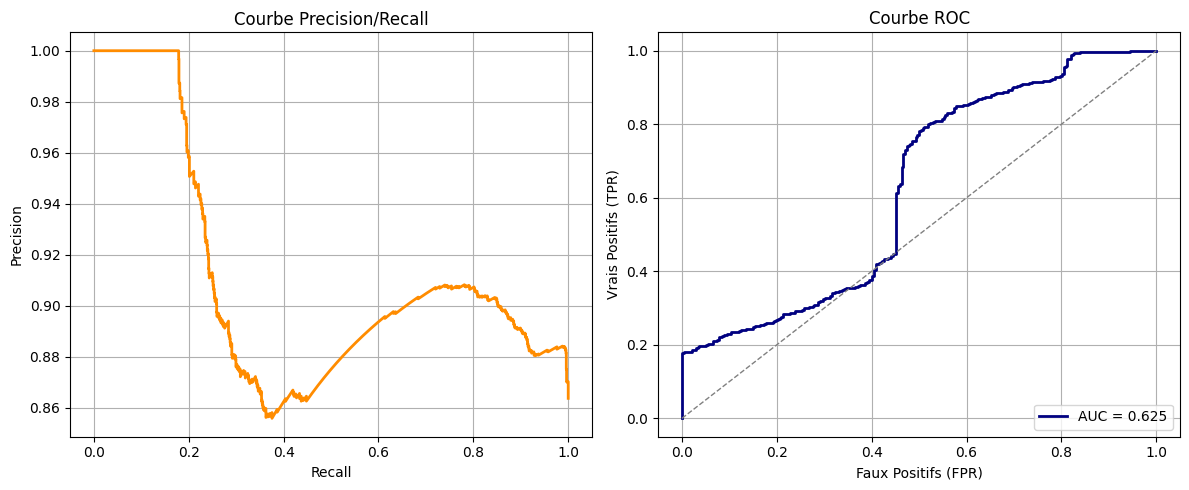

In [96]:
# ‚úÖ √âtape 1 : G√©n√©rer les courbes avec sklearn

from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# üîÅ Si ce n‚Äôest pas encore fait :
# - y_true = ground truth (clips) : gt_clip_labels
# - y_scores = erreurs de reconstruction (losses) : all_losses

y_true = gt_clip_labels
y_scores = all_losses

# üìâ Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# üìà ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# üîç Tracer les courbes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Courbe Precision/Recall
axs[0].plot(recall, precision, color='darkorange', lw=2)
axs[0].set_title("Courbe Precision/Recall")
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].grid(True)

# Courbe ROC
axs[1].plot(fpr, tpr, color='navy', lw=2, label=f"AUC = {roc_auc:.3f}")
axs[1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axs[1].set_title("Courbe ROC")
axs[1].set_xlabel("Faux Positifs (FPR)")
axs[1].set_ylabel("Vrais Positifs (TPR)")
axs[1].legend(loc="lower right")
axs[1].grid(True)

plt.tight_layout()
plt.show()